In [1]:
import os
import openai
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.graph_stores.neo4j import Neo4jGraphStore
from neo4j import GraphDatabase
from llama_index.core import KnowledgeGraphIndex, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import StorageContext
import logging
import sys
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from IPython.display import Markdown, display
from llama_index.core import load_index_from_storage, PromptTemplate
from llama_index.embeddings.openai import OpenAIEmbedding

In [2]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

Please provide your OpenAI Key:  ········


In [4]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# define LLM
llm = OpenAI(model="gpt-4o-mini", temperature=0.1)
embed_model = OpenAIEmbedding(model="text-embedding-3-small")
Settings.llm = llm
Settings.embed_model = embed_model

In [5]:
def load_prompt_template(filepath="resources/text_qa_template.txt"):
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            return PromptTemplate(file.read())
    except Exception as e:
        logging.error(f"Failed to load prompt template: {e}")
        raise
prompt_template = load_prompt_template()

In [6]:
username = "neo4j"
password = "Ss123456$"
url = "bolt://localhost:7687"
embed_dim = 1536
database = "neo4j"

In [8]:
graph_store = Neo4jGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
)

INFO:neo4j.notifications:Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:Entity) REQUIRE (e.id) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_1ed05907 FOR (e:Entity) REQUIRE (e.id) IS UNIQUE` already exists.} {position: None} for query: '\n                CREATE CONSTRAINT IF NOT EXISTS FOR (n:Entity) REQUIRE n.id IS UNIQUE;\n                '


In [7]:
# Base Retriever
# load base index from db
base_index = load_index_from_storage(
    StorageContext.from_defaults(persist_dir="./base_index"), show_progress=True)
print("BASE INDEX LOADED SUCCESSFULLY!!!")
question = "What are the two main tasks BERT is pre-trained on?"
base_query_engine = base_index.as_query_engine(llm, similarity_top_k=2, embed_model=embed_model)
vector_response = base_query_engine.query("What are the two main tasks BERT is pre-trained on?")
print("Base Retriever Response: ", vector_response)

INFO:llama_index.core.indices.loading:Loading all indices.
BASE INDEX LOADED SUCCESSFULLY!!!
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Base Retriever Response:  BERT is pre-trained on two main tasks: masked language modeling and next sentence prediction (NSP).


In [8]:
# Sentence Window Retriever + Sentence Rerank
# load sentence index from db
sentence_index = load_index_from_storage(
    StorageContext.from_defaults(persist_dir="sentence_index"), show_progress=True)
print("SENTENCE INDEX LOADED SUCCESSFULLY!!!")


INFO:llama_index.core.indices.loading:Loading all indices.
SENTENCE INDEX LOADED SUCCESSFULLY!!!


In [9]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor, SentenceTransformerRerank
# define postprocessors
post_proc = MetadataReplacementPostProcessor(target_metadata_key="window")
rerank = SentenceTransformerRerank(
    top_n=2, model="BAAI/bge-reranker-base"
)

sentence_query_engine_rerank = sentence_index.as_query_engine(
    text_qa_template=prompt_template, similarity_top_k=6, embed_model=embed_model,
    llm=llm, node_postprocessors=[post_proc, rerank]
)
sen_window_response = sentence_query_engine_rerank.query("What are the two main tasks BERT is pre-trained on?")
display(Markdown(f"<b>{sen_window_response}</b>"))
print("Sentence Window Retriever + Sentence Rerank Response: ", sen_window_response)

C:\Users\sardo\miniconda3\envs\openai-env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


<b>BERT is pre-trained on masked language modeling and next sentence prediction tasks.</b>

Sentence Window Retriever + Sentence Rerank Response:  BERT is pre-trained on masked language modeling and next sentence prediction tasks.


In [10]:
window_response = sentence_query_engine_rerank.query(question)
print("Window Response: ")
display(Markdown(f"<b>{window_response}</b>"))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Window Response: 


<b>BERT is pre-trained on masked language modeling and next sentence prediction tasks.</b>

In [11]:
window = window_response.source_nodes[0].node.metadata["window"]
sentence = window_response.source_nodes[0].node.metadata["original_text"]
        
print(f"Window: {window}")

Window: BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding
Jacob Devlin
Ming-Wei Chang
Kenton Lee
Kristina Toutanova
Google AI Language
{jacobdevlin,mingweichang,kentonl,kristout}@google.com
Abstract
We introduce a new language representa-
tion model called BERT, which stands for
Bidirectional Encoder Representations from
Transformers.  Unlike recent language repre-
sentation models (Peters et al., 2018a; Rad-
ford et al., 2018), BERT is designed to pre-
train deep bidirectional representations from
unlabeled text by jointly conditioning on both
left and right context in all layers.  As a re-
sult, the pre-trained BERT model can be ﬁne-
tuned with just one additional output layer
to create state-of-the-art models for a wide
range of tasks, such as question answering and
language inference, without substantial task-
speciﬁc architecture modiﬁcations.
 BERT is conceptually simple and empirically
powerful.
 It obtains new state-of-the-art re-
sults on eleven 

In [12]:
print(f"Original Sentence: {sentence}")

Original Sentence: These include sentence-level tasks such as
natural language inference (Bowman et al., 2015;
Williams et al., 2018) and paraphrasing (Dolan
and Brockett, 2005), which aim to predict the re-
lationships between sentences by analyzing them
holistically, as well as token-level tasks such as
named entity recognition and question answering,
where models are required to produce ﬁne-grained
output at the token level (Tjong Kim Sang and
De Meulder, 2003; Rajpurkar et al., 2016).



In [13]:
auto_merging_index = load_index_from_storage(
    StorageContext.from_defaults(persist_dir="index"), show_progress=True)
print("AUTO-MERGE INDEX LOADED SUCCESSFULLY!!!")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/sardo/Documents/DS/GitHub_Projects/final_project/index/docstore.json'

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import AutoMergingRetriever
# Auto-merging retreiever
auto_base_retriever = auto_merging_index.as_retriever(similarity_top_k=6)
auto_merging_query_engine = RetrieverQueryEngine.from_args(
    AutoMergingRetriever(auto_base_retriever, StorageContext.from_defaults(persist_dir="index"), verbose=True))

auto_response = auto_merging_query_engine.query(question)
display(Markdown(f"<b>{auto_response}</b>"))

In [ ]:
knowledge_graph_index = load_index_from_storage(
    StorageContext.from_defaults(persist_dir="./kg_index"))
# Knowledge graph
kg_query_engine = knowledge_graph_index.as_query_engine(
    include_text=False, response_mode="tree_summarize"
)
kg_response = kg_query_engine.query("What are the two main tasks BERT is pre-trained on?")
display(Markdown(f"<b>{kg_response}</b>"))

In [ ]:
kg_query_engine2 = knowledge_graph_index.as_query_engine(
    include_text=True, response_mode="tree_summarize"
)
kg_response2 = kg_query_engine2.query("What are the two main tasks BERT is pre-trained on?")
display(Markdown(f"<b>{kg_response2}</b>"))

In [ ]:
base_knowledge_graph_query = knowledge_graph_index.as_query_engine(
    text_qa_template=prompt_template, include_text=True, response_mode="tree_summarize",
    embedding_mode="hybrid", similarity_top_k=5)

kg_response3 = base_knowledge_graph_query.query("What are the two main tasks BERT is pre-trained on?")
display(Markdown(f"<b>{kg_response3}</b>"))

In [50]:
import pandas as pd

# Load the experimental data from an Excel file
df = pd.read_excel('evaluation_results_experiement_1.xlsx')

In [51]:
df

,Run,Experiment,OverallScores
0,1,Naive RAG,"{'retrieval_precision': 0.6428571428571429, 'a..."
1,2,Naive RAG,"{'retrieval_precision': 0.6428571428571429, 'a..."
2,3,Naive RAG,"{'retrieval_precision': 0.6428571428571429, 'a..."
3,1,Sentence window retrieval,"{'retrieval_precision': 0.6904761904761905, 'a..."
4,2,Sentence window retrieval,"{'retrieval_precision': 0.6904761904761905, 'a..."
5,3,Sentence window retrieval,"{'retrieval_precision': 0.6904761904761905, 'a..."
6,1,Sentence window retrieval + Sentence rerank,"{'retrieval_precision': 0.7678571428571429, 'a..."
7,2,Sentence window retrieval + Sentence rerank,"{'retrieval_precision': 0.7678571428571429, 'a..."
8,3,Sentence window retrieval + Sentence rerank,"{'retrieval_precision': 0.7678571428571429, 'a..."
9,1,Auto-merging retrieval,"{'retrieval_precision': 0.5220238095238096, 'a..."


In [48]:
import pandas as pd

# Load the experimental data from an Excel file
df_experiement2 = pd.read_excel('evaluation_results_experiement_2.xlsx')
df_experiement2

,Run,Experiment,OverallScores
0,1,Naive RAG,"{'retrieval_precision': 0.4666666666666666, 'a..."
1,2,Naive RAG,"{'retrieval_precision': 0.4666666666666666, 'a..."
2,3,Naive RAG,"{'retrieval_precision': 0.4666666666666666, 'a..."
3,1,Sentence window retrieval,"{'retrieval_precision': 0.5666666666666667, 'a..."
4,2,Sentence window retrieval,"{'retrieval_precision': 0.5666666666666667, 'a..."
5,3,Sentence window retrieval,"{'retrieval_precision': 0.5666666666666667, 'a..."
6,1,Sentence window retrieval + Sentence rerank,"{'retrieval_precision': 0.65, 'answer_similari..."
7,2,Sentence window retrieval + Sentence rerank,"{'retrieval_precision': 0.65, 'answer_similari..."
8,3,Sentence window retrieval + Sentence rerank,"{'retrieval_precision': 0.65, 'answer_similari..."
9,1,Auto-merging retrieval,"{'retrieval_precision': 0.32333333333333336, '..."


In [13]:
import ast

# Parse the 'OverallScores' column to convert string representations of dictionaries into actual dictionaries
try:
    df['OverallScores'] = df['OverallScores'].apply(ast.literal_eval)
except ValueError as e:
    print(f"Error encountered: {e}")

# Extract these dictionaries into separate columns and combine with the original DataFrame
metrics_df = df['OverallScores'].apply(pd.Series)
expanded_data = pd.concat([df.drop(columns=['OverallScores']), metrics_df], axis=1)

# Display the first few rows to verify the transformation
expanded_data.head()

,Run,Experiment,retrieval_precision,answer_similarity,answer_consistency,augmentation_precision,augmentation_accuracy
0,1,Naive RAG,0.642857,3.500000,0.946429,0.797619,0.785714
1,2,Naive RAG,0.642857,3.535714,0.970238,0.797619,0.785714
2,3,Naive RAG,0.642857,3.500000,0.964286,0.797619,0.773810
3,1,Sentence window retrieval,0.690476,3.142857,0.939286,0.982143,0.845238
4,2,Sentence window retrieval,0.690476,3.142857,0.937500,1.000000,0.857143


In [25]:
import ast

# Parse the 'OverallScores' column to convert string representations of dictionaries into actual dictionaries
try:
    df_experiement2['OverallScores'] = df_experiement2['OverallScores'].apply(ast.literal_eval)
except ValueError as e:
    print(f"Error encountered: {e}")

# Extract these dictionaries into separate columns and combine with the original DataFrame
metrics_df = df_experiement2['OverallScores'].apply(pd.Series)
expanded_data_2 = pd.concat([df_experiement2.drop(columns=['OverallScores']), metrics_df], axis=1)

# Display the first few rows to verify the transformation
expanded_data_2.head()

,Run,Experiment,retrieval_precision,answer_similarity,answer_consistency,latency_metric
0,1,Naive RAG,0.466667,3.6,0.925000,1.0
1,2,Naive RAG,0.466667,3.6,0.933333,1.0
2,3,Naive RAG,0.466667,3.6,0.933333,1.0
3,1,Sentence window retrieval,0.566667,3.0,0.883333,1.0
4,2,Sentence window retrieval,0.566667,3.1,0.916667,1.0


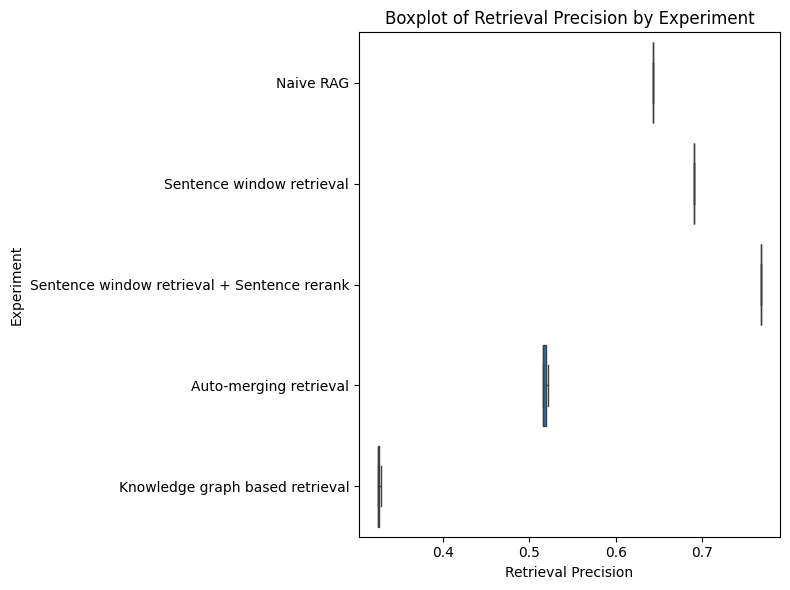

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of Retrieval Precision across different experiments
plt.figure(figsize=(8, 6))
sns.boxplot(x='retrieval_precision', y='Experiment', data=expanded_data, orient='h', legend=False)
plt.title('Boxplot of Retrieval Precision by Experiment')
plt.xlabel('Retrieval Precision')
plt.ylabel('Experiment')
plt.tight_layout()
plt.show()



C:\Users\sardo\AppData\Local\Temp\ipykernel_27420\917669894.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='answer_similarity', y='Experiment', data=expanded_data, palette="Set3", orient='h')


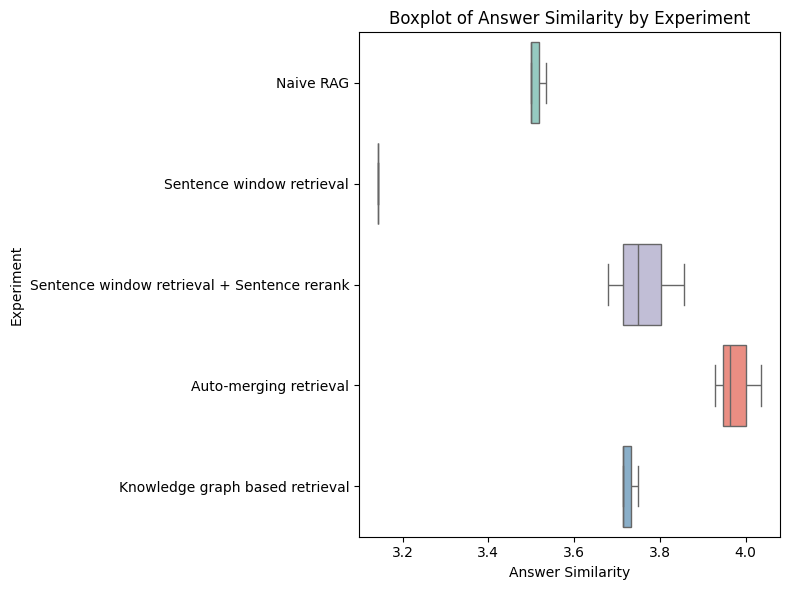

In [23]:
# Visualization of Answer Similarity across different experiments
plt.figure(figsize=(8, 6))
sns.boxplot(x='answer_similarity', y='Experiment', data=expanded_data, palette="Set3", orient='h')
plt.title('Boxplot of Answer Similarity by Experiment')
plt.xlabel('Answer Similarity')
plt.ylabel('Experiment')
plt.tight_layout()
plt.show()





C:\Users\sardo\AppData\Local\Temp\ipykernel_27420\1357992049.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='latency_metric', y='Experiment', data=expanded_data_2, palette="Set3", orient='h')


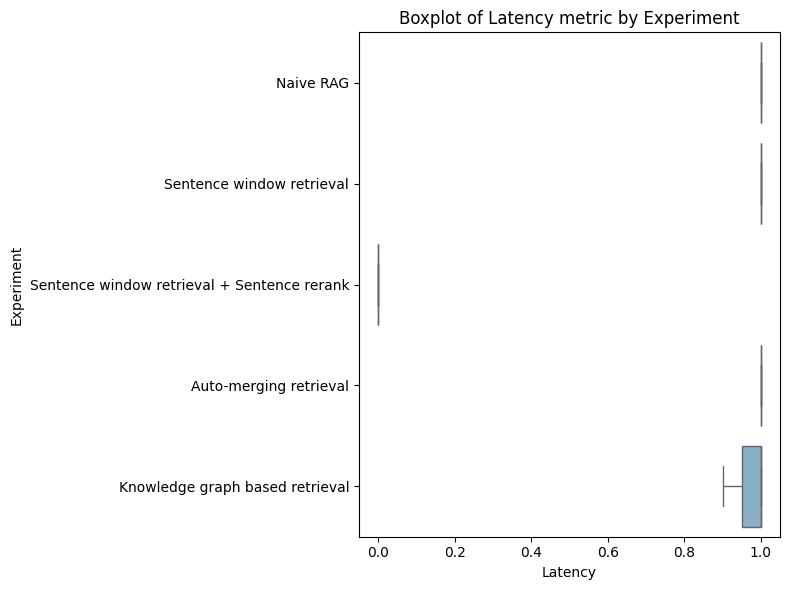

In [47]:
# Visualization of Answer Similarity across different experiments
plt.figure(figsize=(8, 6))
sns.boxplot(x='latency_metric', y='Experiment', data=expanded_data_2, palette="Set3", orient='h')
plt.title('Boxplot of Latency metric by Experiment')
plt.xlabel('Latency')
plt.ylabel('Experiment')
plt.tight_layout()
plt.show()





In [33]:
from scipy.stats import f_oneway

# ANOVA for retrieval precision and answer similarity
groups_rp = expanded_data.groupby('Experiment')['retrieval_precision'].apply(list)
groups_as = expanded_data.groupby('Experiment')['answer_similarity'].apply(list)

anova_rp = f_oneway(*groups_rp)
anova_as = f_oneway(*groups_as)

anova_results = {
    'Retrieval Precision': {'statistic': anova_rp.statistic, 'p-value': anova_rp.pvalue},
    'Answer Similarity': {'statistic': anova_as.statistic, 'p-value': anova_as.pvalue}
}

anova_results

{'Retrieval Precision': {'statistic': 29205.678407665553,
  'p-value': 2.75611891915746e-20},
 'Answer Similarity': {'statistic': 125.23214285714215,
  'p-value': 1.6951513649734617e-08}}

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

tukey_rp = pairwise_tukeyhsd(endog=expanded_data['retrieval_precision'], groups=expanded_data['Experiment'], alpha=0.05)
tukey_result_df = pd.DataFrame(data=tukey_rp.summary().data[1:], columns=tukey_rp.summary().data[0])
tukey_result_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Auto-merging retrieval,Knowledge graph based retrieval,-0.1920,0.0,-0.1967,-0.1873,True
1,Auto-merging retrieval,Naive RAG,0.1248,0.0,0.1201,0.1295,True
2,Auto-merging retrieval,Sentence window retrieval,0.1724,0.0,0.1677,0.1771,True
3,Auto-merging retrieval,Sentence window retrieval + Sentence rerank,0.2498,0.0,0.2451,0.2545,True
4,Knowledge graph based retrieval,Naive RAG,0.3168,0.0,0.3121,0.3215,True
5,Knowledge graph based retrieval,Sentence window retrieval,0.3644,0.0,0.3597,0.3691,True
6,Knowledge graph based retrieval,Sentence window retrieval + Sentence rerank,0.4418,0.0,0.4371,0.4465,True
7,Naive RAG,Sentence window retrieval,0.0476,0.0,0.0429,0.0523,True
8,Naive RAG,Sentence window retrieval + Sentence rerank,0.1250,0.0,0.1203,0.1297,True
9,Sentence window retrieval,Sentence window retrieval + Sentence rerank,0.0774,0.0,0.0727,0.0821,True


In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Apply Tukey's HSD test for 'retrieval_precision' across different 'Experiment' groups
tukey_rp = pairwise_tukeyhsd(endog=expanded_data['retrieval_precision'], groups=expanded_data['Experiment'], alpha=0.05)

# Convert the result into a DataFrame for better readability
tukey_result_df = pd.DataFrame(data=tukey_rp.summary().data[1:], columns=tukey_rp.summary().data[0])
tukey_result_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Auto-merging retrieval,Knowledge graph based retrieval,-0.1920,0.0,-0.1967,-0.1873,True
1,Auto-merging retrieval,Naive RAG,0.1248,0.0,0.1201,0.1295,True
2,Auto-merging retrieval,Sentence window retrieval,0.1724,0.0,0.1677,0.1771,True
3,Auto-merging retrieval,Sentence window retrieval + Sentence rerank,0.2498,0.0,0.2451,0.2545,True
4,Knowledge graph based retrieval,Naive RAG,0.3168,0.0,0.3121,0.3215,True
5,Knowledge graph based retrieval,Sentence window retrieval,0.3644,0.0,0.3597,0.3691,True
6,Knowledge graph based retrieval,Sentence window retrieval + Sentence rerank,0.4418,0.0,0.4371,0.4465,True
7,Naive RAG,Sentence window retrieval,0.0476,0.0,0.0429,0.0523,True
8,Naive RAG,Sentence window retrieval + Sentence rerank,0.1250,0.0,0.1203,0.1297,True
9,Sentence window retrieval,Sentence window retrieval + Sentence rerank,0.0774,0.0,0.0727,0.0821,True


In [36]:
# Filter Tukey HSD results to focus on specific group comparisons
filtered_results = tukey_result_df[
    (tukey_result_df['group1'] == "Naive RAG") |
    (tukey_result_df['group2'] == "Naive RAG")
]
filtered_results

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Auto-merging retrieval,Naive RAG,0.1248,0.0,0.1201,0.1295,True
4,Knowledge graph based retrieval,Naive RAG,0.3168,0.0,0.3121,0.3215,True
7,Naive RAG,Sentence window retrieval,0.0476,0.0,0.0429,0.0523,True
8,Naive RAG,Sentence window retrieval + Sentence rerank,0.1250,0.0,0.1203,0.1297,True


In [37]:
# Focus on experiments for a detailed comparison
experiments_focus_group1 = [
    "Sentence window retrieval + Sentence rerank",
    "Naive RAG",
    "Sentence window retrieval",
    "Auto-merging retrieval",
    "Knowledge graph based retrieval"
]

filtered_results = tukey_result_df[
    tukey_result_df['group1'].isin(experiments_focus_group1) &
    (tukey_result_df['group2'] == "Naive RAG")
]
filtered_results


,group1,group2,meandiff,p-adj,lower,upper,reject
1,Auto-merging retrieval,Naive RAG,0.1248,0.0,0.1201,0.1295,True
4,Knowledge graph based retrieval,Naive RAG,0.3168,0.0,0.3121,0.3215,True


In [38]:
# Focus on experiments for a detailed comparison
experiments_focus_group1 = [
    "Sentence window retrieval + Sentence rerank",
    "Naive RAG",
    "Sentence window retrieval",
    "Auto-merging retrieval",
    "Knowledge graph based retrieval"
]

filtered_results = tukey_result_df[
    tukey_result_df['group1'].isin(experiments_focus_group1) &
    tukey_result_df['group2'].isin(experiments_focus_group1)
]
filtered_results

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Auto-merging retrieval,Knowledge graph based retrieval,-0.1920,0.0,-0.1967,-0.1873,True
1,Auto-merging retrieval,Naive RAG,0.1248,0.0,0.1201,0.1295,True
2,Auto-merging retrieval,Sentence window retrieval,0.1724,0.0,0.1677,0.1771,True
3,Auto-merging retrieval,Sentence window retrieval + Sentence rerank,0.2498,0.0,0.2451,0.2545,True
4,Knowledge graph based retrieval,Naive RAG,0.3168,0.0,0.3121,0.3215,True
5,Knowledge graph based retrieval,Sentence window retrieval,0.3644,0.0,0.3597,0.3691,True
6,Knowledge graph based retrieval,Sentence window retrieval + Sentence rerank,0.4418,0.0,0.4371,0.4465,True
7,Naive RAG,Sentence window retrieval,0.0476,0.0,0.0429,0.0523,True
8,Naive RAG,Sentence window retrieval + Sentence rerank,0.1250,0.0,0.1203,0.1297,True
9,Sentence window retrieval,Sentence window retrieval + Sentence rerank,0.0774,0.0,0.0727,0.0821,True


In [39]:
# Filter the Tukey HSD results for comparisons involving "Sentence window retrieval"
filtered_results = tukey_result_df[
    (tukey_result_df['group1'] == "Sentence window retrieval")
]

filtered_results

,group1,group2,meandiff,p-adj,lower,upper,reject
9,Sentence window retrieval,Sentence window retrieval + Sentence rerank,0.0774,0.0,0.0727,0.0821,True


In [41]:
# Filter the Tukey HSD results for comparisons involving "Sentence window retrieval + Sentence rerank"
filtered_results = tukey_result_df[
    (tukey_result_df['group2'] == "Sentence window retrieval + Sentence rerank")
]

filtered_results

,group1,group2,meandiff,p-adj,lower,upper,reject
3,Auto-merging retrieval,Sentence window retrieval + Sentence rerank,0.2498,0.0,0.2451,0.2545,True
6,Knowledge graph based retrieval,Sentence window retrieval + Sentence rerank,0.4418,0.0,0.4371,0.4465,True
8,Naive RAG,Sentence window retrieval + Sentence rerank,0.1250,0.0,0.1203,0.1297,True
9,Sentence window retrieval,Sentence window retrieval + Sentence rerank,0.0774,0.0,0.0727,0.0821,True


In [44]:
# Filter for broader comparisons across selected experiments
filtered_results = tukey_result_df[
    tukey_result_df['group1'].isin([
        "Sentence window retrieval",
        "Sentence window retrieval + Sentence rerank",
        "Naive RAG",
        "Document summary index + Rerank"
    ]) & tukey_result_df['group2'].isin([
        "Sentence window retrieval",
        "Sentence window retrieval + Sentence rerank",
        "Naive RAG",
        "Document summary index + Rerank"
    ])
]
print(filtered_results)

                      group1                                       group2  \
7                  Naive RAG                    Sentence window retrieval   
8                  Naive RAG  Sentence window retrieval + Sentence rerank   
9  Sentence window retrieval  Sentence window retrieval + Sentence rerank   

   meandiff  p-adj   lower   upper  reject  
7    0.0476    0.0  0.0429  0.0523    True  
8    0.1250    0.0  0.1203  0.1297    True  
9    0.0774    0.0  0.0727  0.0821    True  
